In [75]:
#imports
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from tensorflow import 



In [76]:
# READ csv
df = pd.read_csv('Data/train/train_data1.csv')
split = int(round(len(list(df.iloc[:,1]))*0.5)) #<--- Can change to 0.4,0.2 etc depending on the data
#FOR MODELING AND TESTING
x = df.iloc[:,1][:split]
y = df.iloc[:,2][:split]

#FOR FINAL DEMO. 
x_2 = df.iloc[:,1][split:]
y_2 = df.iloc[:,2][split:]
print(split,len(list(df.iloc[:,1])))
print('len x_2', len(list(x_2)))
print('len x', len(list(x)))


2048 4095
len x_2 2047
len x 2048


In [77]:
# Generate training splits
len_hist = 20 # Number of previous points to represent current 
x_data = []
y_data = []

index = len_hist
while index < len(list(x)):
    x_data.append(list(x)[index-len_hist:index])
    y_data.append(list(y)[index])
    index +=1
print(len(x_data),len(y_data))


2028 2028


In [78]:
# Same for demo/test:
x_demo = []
y_demo = []

index = len_hist
while index < len(list(x_2)):
    x_demo.append(list(x_2)[index-len_hist:index])
    y_demo.append(list(y_2)[index])
    index +=1
print(len(x_demo),len(y_demo))

2027 2027


In [109]:
# Make dataset even:
ratio = 0.80 # ratio between negatives and positives. Default 1. Increasing gives recall precision tradeoff up to a point
total = 0
zeros = 0
types = []
x_balanced = []
y_balanced = []
num_pos = np.sum([i for i in y_data if i==1]) # Will always have more negatives than positives so we threshold by num_pos
for x,y in zip(x_data,y_data):
    if y == 1.0: 
        x_balanced.append(x)
        y_balanced.append(y)
        total+=1
    if y == 0:
        if zeros < num_pos*ratio: # Make sure we only end up with the same number of postives as negative samples!
            x_balanced.append(x)
            y_balanced.append(y)
        zeros +=1
X_train, X_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.20, random_state=42,shuffle=True)

Test Scores 0.8125
Demo Scores (test scores true) 0.7631968426245683
Test precision 0.8266666666666667
Test recall 0.8157894736842105
Demo precision 0.4102920723226704
Demo recall 0.8404558404558404


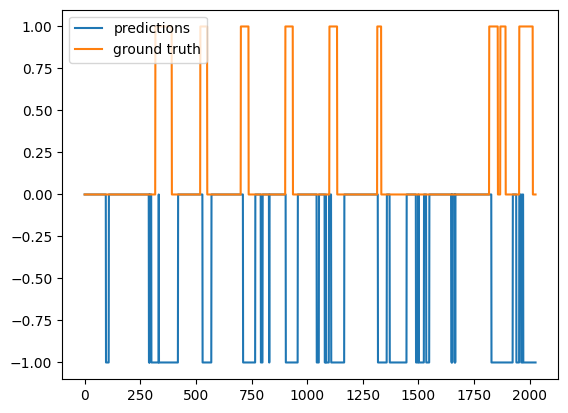

In [110]:
#Train model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("Test Scores", clf.score(X_test,y_test))
print("Demo Scores (test scores true)", clf.score(x_demo,y_demo))
print("Test precision",precision_score(y_test, list(clf.predict(X_test)), pos_label=1))
print("Test recall",recall_score(y_test, list(clf.predict(X_test)), pos_label=1))

print("Demo precision",precision_score(y_demo, list(clf.predict(x_demo)), pos_label=1))
print("Demo recall",recall_score(y_demo, list(clf.predict(x_demo)), pos_label=1))




# View model:
predictions = []
predictions += list(clf.predict(x_demo))
plt.plot([x*-1 for x in predictions], label ='predictions')

plt.plot(y_demo,label = 'ground truth')
plt.legend()

NOTE: We can ignore the last couple of positives as this was just our data collector signaling that we are ending sample collection by rapidly tapping the photoresistor. 

*We only care about the points prior 1000 here*

We can see we have a lot of false positives (which are much better than false negatives!). In practice, we can tell our model to wait for x number of positive predictions in a row to be detected before turning on the break. Let's see how this might look by smoothing our the predictions.

In [106]:
def filtBreak(data,min_len):
    """
    This function takes in an 1D array or list of binary data and filters out cases where sequences of 1s
    are less than "min_len" 
    Inputs:
    - data (array or list):
    - min_len ()

    Ouputs:
    - filtered_data (np.array): filtered sequences
    """
    result = []
    count = 0

    for val in data:
        if val == 1:
            count += 1
        else:
            if count < min_len:
                result.extend([0] * count)
            else:
                result.extend([1] * count)
            result.append(val)
            count = 0

    if count < min_len:
        result.extend([0] * count)
    else:
        result.extend([1] * count)
    return result


# Define test inputs
test_data = np.array([1,1,1,0,0,1,0])
min_len = 3

# Define expected output
expected_output = np.array([1,1,1,0,0,0,0])

# Test the function
print(filtBreak(test_data,2))
assert(list(filtBreak(test_data,2))==list(expected_output))

# Print the results
print("Test passed!")


[1, 1, 1, 0, 0, 0, 0]
Test passed!


new recall 0.8233618233618234
new precision 0.4857142857142857
recall ratio change (Greater than 0 means improvement) -0.020338983050847387
precision ratio change (Greater than 0 means improvement) 0.18382566585956409


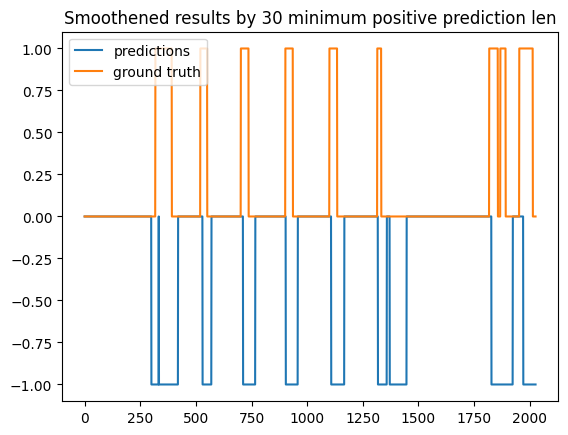

In [111]:
# Smooth results
# While we couldn't do this in practice, it's good to see the noise we have. 
# If we leave a min_len buffer before starting inference, we'd effectively get the below result
min_len = 30
predictions_filt = filtBreak(list(predictions),min_len)
plt.plot([x*-1 for x in predictions_filt], label ='predictions')
plt.plot(y_demo,label = 'ground truth')
plt.title(f'Smoothened results by {min_len} minimum positive prediction len')
plt.legend()
print("new recall",recall_score(y_demo, predictions_filt, pos_label=1))
print("new precision",precision_score(y_demo, predictions_filt, pos_label=1))
new_prec = float(precision_score(y_demo, predictions_filt, pos_label=1))
old_prec = float(precision_score(y_demo, list(clf.predict(x_demo)), pos_label=1))

new_recall = float(recall_score(y_demo, predictions_filt, pos_label=1))
old_recall = float(recall_score(y_demo, list(clf.predict(x_demo)), pos_label=1))


print("recall ratio change (Greater than 0 means improvement)",(new_recall-old_recall)/old_recall)
print("precision ratio change (Greater than 0 means improvement)",(new_prec-old_prec)/old_prec)


In [93]:
# # Define the logistic regression model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(10, activation = 'relu', input_dim=len_hist),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=100)

# # Evaluate the model on the test set
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test loss: {loss}")
# print(f"Test accuracy: {accuracy}")

In [ ]:
# model.predict(X_train)

In [ ]:
# # View model:
# predictions = [0 for i in range(len_hist)]
# predictions += model.predict(x_data)
# plt.plot(y_data,label = 'ground truth')
# plt.plot(predictions, label ='predictions')